In [ ]:
!pip install transformers scipy scikit-learn

In [ ]:
import json
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from scipy.stats import spearmanr
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
with open("train.json") as f:
    train_data = json.load(f)

with open("dev.json") as f:
    dev_data = json.load(f)

In [ ]:
def story_key(sample):
    return (
        sample["precontext"].strip(),
        sample["sentence"].strip(),
        sample["ending"].strip()
    )

train_stories = defaultdict(list)
for t_s in train_data.values():
    train_stories[story_key(t_s)].append(t_s)

dev_stories = defaultdict(list)
for d_s in dev_data.values():
    dev_stories[story_key(d_s)].append(d_s)

In [ ]:
train_keys = list(train_stories.keys())
val_keys = list(dev_stories.keys())


def collect(keys, stories):
    samples = []
    for k in keys:
        samples.extend(stories[k])
    return samples


train_samples = collect(train_keys, train_stories)
val_samples = collect(val_keys, dev_stories)

print(len(train_samples), len(val_samples))


2280 588


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

class AmbiStoryDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        ending = s["ending"].strip()
        if ending == "":
            ending = "[NO ENDING]"

        story = f"{s['precontext']} {s['sentence']} {ending}"
        sense = f"{s['judged_meaning']}. {s['example_sentence']}"

        enc = tokenizer(
            story,
            sense,
            truncation=True,
            padding="max_length",
            max_length=256,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "label": torch.tensor(s["average"], dtype=torch.float),
            "stdev": torch.tensor(s["stdev"], dtype=torch.float),
            "story_id": story_key(s)
        }


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
train_ds = AmbiStoryDataset(train_samples)
val_ds = AmbiStoryDataset(val_samples)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

In [ ]:
class OrdinalRoBERTa(nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.head = nn.Linear(768, 1)
        nn.init.constant_(self.head.bias, 3.0)

    def forward(self, input_ids, attention_mask):
        out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_rep = out.last_hidden_state[:, 0, :]
        score = self.head(cls_rep).squeeze()
        return score

In [ ]:
def ranking_loss(preds, labels, story_ids, margin=0.5):
    loss = 0.0
    count = 0

    by_story = defaultdict(list)
    for p, y, sid in zip(preds, labels, story_ids):
        by_story[sid].append((p, y))

    for pairs in by_story.values():
        if len(pairs) < 2:
            continue
        (p1, y1), (p2, y2) = pairs[:2]
        if y1 == y2:
            continue
        sign = torch.sign(y1 - y2)
        loss += torch.relu(margin - sign * (p1 - p2))
        count += 1

    return loss / max(count, 1)

In [ ]:
def evaluate(model, loader):
    model.eval()
    preds, gold = [], []

    with torch.no_grad():
        for batch in loader:
            p = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )
            preds.extend(torch.clamp(p, 1.0, 5.0).cpu().numpy())
            gold.extend(batch["label"].numpy())

            print("Pred min/max:", min(preds), max(preds))

    return spearmanr(preds, gold).correlation, preds, gold

In [ ]:
model = OrdinalRoBERTa().to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)

mse = nn.MSELoss()
lam = 1.0

train_losses, val_spearman = [], []
best_val = -1

for epoch in range(10):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        preds = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        )

        labels = batch["label"].to(device)
        r_loss = ranking_loss(preds, labels,
                              batch["story_id"])
        m_loss = mse(preds, labels)

        loss = m_loss + lam * r_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    sp, _, _ = evaluate(model, val_loader)
    val_spearman.append(sp)

    if sp > best_val:
        best_val = sp
        torch.save(model.state_dict(), "best_model.pt")

    print(f"Epoch {epoch+1} | Loss {train_losses[-1]:.4f} | Val Spearman {sp:.4f}")


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pred min/max: 3.0230138 3.0231621
Pred min/max: 3.0229778 3.0231621
Pred min/max: 3.022943 3.0233123
Pred min/max: 3.022943 3.023495
Pred min/max: 3.022943 3.023495
Pred min/max: 3.022943 3.023495
Pred min/max: 3.022943 3.023495
Pred min/max: 3.022943 3.023495
Pred min/max: 3.022943 3.023495
Pred min/max: 3.022943 3.023495
Pred min/max: 3.022943 3.023496
Pred min/max: 3.022943 3.023496
Pred min/max: 3.022943 3.023496
Pred min/max: 3.022943 3.023496
Pred min/max: 3.0228925 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.0227485 3.023496
Pred min/max: 3.022

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

final_spearman, final_preds, final_gold = evaluate(model, val_loader)
print("FINAL Spearman:", final_spearman)

correct = 0
for p, g, s in zip(final_preds, final_gold, val_ds.samples):
    if abs(p - g) <= max(1.0, s["stdev"]):
        correct += 1

print("Accuracy within STD:", correct / len(final_gold))


Pred min/max: 3.2003808 3.2010336
Pred min/max: 3.2002463 3.2010336
Pred min/max: 3.2002463 3.2012107
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.2002463 3.2014756
Pred min/max: 3.200246 3.2014756
Pred min/max: 3.200246 3.2014756
Pred min/max: 3.200246 3.2014756
Pred min/max: 3.200246 3.2014756
Pred min/max: 3.200246 3.2014756
Pred min/max: 3.200246 3.2014856
Pred min/max: 3.200246 3.2020192
Pred min/max: 3.200246 3.2020192
Pred min/max: 3.200246 3.2020192
Pred min/max: 3.200246 3.2020192
Pred min/max: 3.200246 3.2020192
Pred min/max: 3.200246 3.2020192
Pred min/max: 3.200246 3.2020192
Pred min/max: 3.200246 3.2020192
Pred min/max: 3.200246 3.202

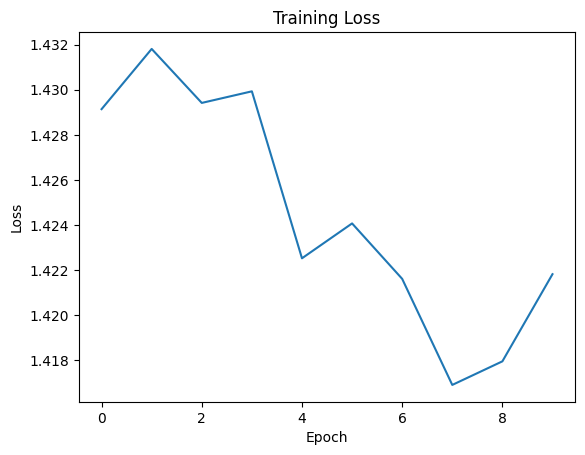

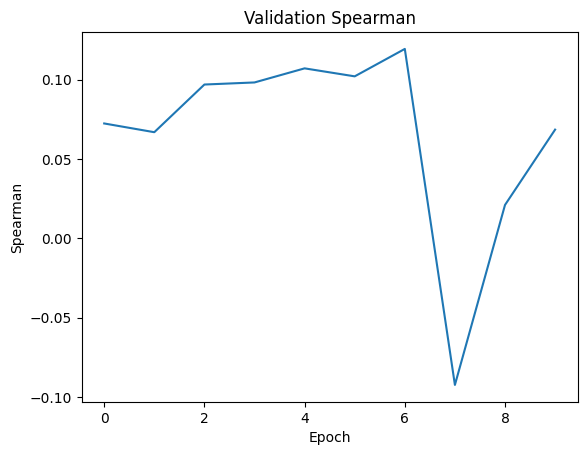

In [ ]:
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(val_spearman)
plt.title("Validation Spearman")
plt.xlabel("Epoch")
plt.ylabel("Spearman")
plt.show()

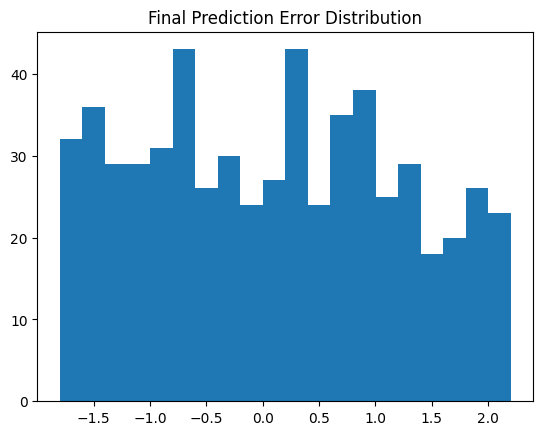

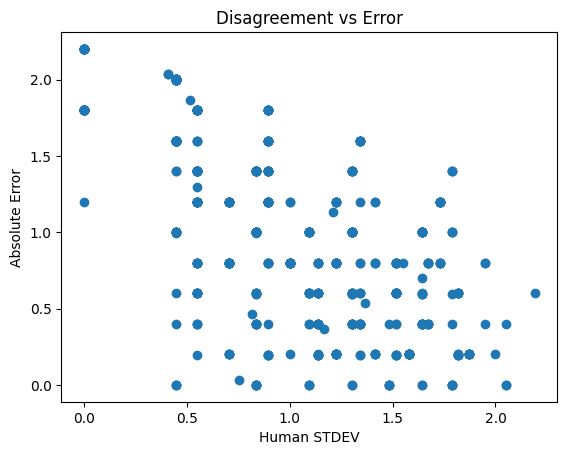

In [ ]:
errors = np.array(final_preds) - np.array(final_gold)

plt.figure()
plt.hist(errors, bins=20)
plt.title("Final Prediction Error Distribution")
plt.show()

plt.figure()
plt.scatter(
    [s["stdev"] for s in val_ds.samples],
    np.abs(errors)
)
plt.xlabel("Human STDEV")
plt.ylabel("Absolute Error")
plt.title("Disagreement vs Error")
plt.show()